In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import glob
import re

In [31]:
"""
Noise Approximation

This script navigates through the experiment's main folder to locate the subfolder that contains the noise measurement files.
Note: The subfolder must be named 'noise'.
Note: The name of each file needs to be written with ',' between different info and contain the angle
      in the following manner - "angle={number}" 

Within this 'noise' subfolder, it iterates over each file (each representing a different angle) and extracts the following 
information:
    
1. The angle between the polarization axes.
2. The average photon count per time bin measurement.
3. The standard deviation of the measurements.

These values are stored in specific lists: `angles1`, `data_avgs1`, and `data_stds1`,
each with corresponding indices for easy reference.

### Input:
- 'main_directory': The path to the main folder of the experiment.

### Output:
- 'Noise': A dictionary with a single key ('noise') that holds a list of tuples. 
           Each tuple contains values from `data_avgs1`, `data_stds1`, and `angles1` with matching indices.
  
- 'noise_avg': A variable representing the mean of the average photon counts across different angles.
- 'noise_std': A variable that combines the standard deviations of the average measurements for each angle.

Assumption: The 'noise' subfolder contains exactly two files, 
            each representing noise data for angles of 0 degrees and 90 degrees, respectively.
"""


#Location of the experiment's folder.
main_directory = r"D:\TAU\Final_Project\final mes"

# Initialize a dictionary to store results
Noise = {}

# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(main_directory) if f.is_dir()]

# Process each subfolder (parameter value)
for subfolder in subfolders:
    # Extract the parameter value from the subfolder name
    param_value = os.path.basename(subfolder)
    #Checks if it is the wanted subfolder.
    if param_value == 'noise':
        # Initialize lists to store results for this subfolder
        angles1 = []
        data_avgs1 = []
        data_stds1 = []

        # Get the list of files in the current subfolder
        files = glob.glob(os.path.join(subfolder, '*'))

        # Process each file in the subfolder
        for file_path in files:
            file_name = os.path.basename(file_path)

            with open(file_path, "r") as f:
                df = pd.read_csv(f, sep='\t')

                parts = file_name.split(',')
                angle_loc = [i for i, part in enumerate(parts) if 'angle' in part]
                if angle_loc:
                    angle = float(parts[angle_loc[0]].split('=')[1])
                    angles1.append(angle)

                data_avg = np.mean(np.array(df.iloc[:, 1]))
                data_std = np.std(np.array(df.iloc[:, 1])) / np.sqrt(len(np.array(df.iloc[:, 1])))

                data_avgs1.append(data_avg)
                data_stds1.append(data_std)

        # Store results in the dictionary with the parameter value as the key
        Noise[param_value] = list(zip(data_avgs1, data_stds1, angles1))
        noise_avg = np.mean([Noise['noise'][0][0],Noise['noise'][1][0]])
        noise_std = np.sqrt((Noise['noise'][0][1]**2 + Noise['noise'][1][1]**2) * 1e-12)


In [3]:
"""
Data Processing After Noise Subtraction

This script navigates through the main experiment folder, processing each subfolder except the 'noise' subfolder.
For each file within these subfolders, it subtracts the average noise value from the data and combines the noise 
standard deviation (STD) with the measurement STD to account for background noise.

### Input:
- 'main_directory': The path to the main experiment folder.

### Output:
- 'results': A dictionary where each key corresponds to a subfolder name (representing different wind speeds) 
             and the value is a list of tuples. Each tuple contains values from `data_avgs1`, `data_stds1`, and `angles1`
             with aligned indices.
  
- 'angles1': A list of measured angles.
- 'data_avgs1': A list containing the mean photon count values for each corresponding angle.
- 'data_stds1': A list containing the standard deviations of the photon counts for each corresponding angle.

"""


# Set the main directory containing subfolders
main_directory = r"D:\TAU\Final_Project\final mes"

# Initialize a dictionary to store results
results = {}

# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(main_directory) if f.is_dir()]

# Process each subfolder (parameter value)
for subfolder in subfolders:
    # Extract the parameter value from the subfolder name
    param_value = os.path.basename(subfolder)
    
    if param_value != 'noise':
    
        # Initialize lists to store results for this subfolder
        angles1 = []
        data_avgs1 = []
        data_stds1 = []

        # Get the list of files in the current subfolder
        files = glob.glob(os.path.join(subfolder, '*'))

        # Process each file in the subfolder
        for file_path in files:
            file_name = os.path.basename(file_path)

            with open(file_path, "r") as f:
                df = pd.read_csv(f, sep='\t')

                parts = file_name.split(',')
                angle_loc = [i for i, part in enumerate(parts) if 'angle' in part]
                if angle_loc:
                    angle = float(parts[angle_loc[0]].split('=')[1])
                    angles1.append(angle)
                    
                #Angle variables.
                data_avg = np.mean(np.array(df.iloc[:, 1])) - noise_avg
                data_std = np.std(np.array(df.iloc[:, 1])) / np.sqrt(len(np.array(df.iloc[:, 1])))

                #Final variables
                data_avgs1.append(data_avg)
                data_stds1.append(np.sqrt(data_std**2 + noise_std**2))

        # Store results in the dictionary with the parameter value as the key
        results[param_value] = list(zip(data_avgs1, data_stds1, angles1))

    # Now `results` dictionary contains the desired data structure


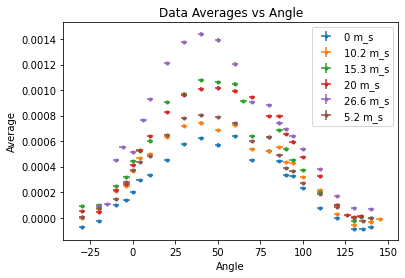

In [32]:
"""
Graphing the Data

This section iterates through all the data, plotting it on a single graph for easy comparison.
Additionally, it provides an initial estimation for the fitting parameters required in the next section.

The data is organized to ensure that angles are sorted from lowest to highest.
This is achieved by reordering the indices in the following lists: 'angles', 'values', and 'error'.

"""


#Go over each file's data excepts the 'noise' and the file we don't want it to use.
for j,folder in enumerate([i for i in results.keys() if  i != '10.2 m_s - no fan']):    
    
    #Reorganize the data according to lower to higher angle. 
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2,:][np.argsort(data[2,:])]
    values = data[0,:][np.argsort(data[2,:])]
    error = data[1,:][np.argsort(data[2,:])]

    #Adds the errorbar plot of the file to the general plot canvas.
    plt.errorbar(np.array(angles), np.array(values),
                 np.array(error),2*np.ones(len(angles)),'.', label=f"{folder}")

#Plot the general canvas with all the added plots.     
plt.xlabel('Angle')
plt.ylabel('Average')
plt.title('Data Averages vs Angle')
plt.legend()
plt.show()

In [34]:
"""
Fitting Data

Using the data collected in the previous section, this part fits each wind speed dataset (from each subfolder) to
a cos² function as per classical theory—Malus' Law.

The data is first organized to ensure angles are sorted from lowest to highest by reordering the indices 
in the 'angles', 'values', and 'error' lists.

### Input:
- 'p0': Initial guesses for the parameters of the fit function defined in 'func()'', derived from the plot values
        in the previous section.

### Output:
- 'fit': A dictionary where each key is a subfolder name and each value is a list containing the fit parameters 
         and covariance.
         The fit parameters correspond to the following indices in 'func()'': A, B, C, D.
         
"""

from scipy.optimize import curve_fit

#Def. the calssical function of Malus' Law with free parameters.
def func(x, A, B, C, D):
    y= A*(np.cos((2*np.pi/180)*B*(x-C))**2)+ D
    return y
  
#Dict. for the fit parameters    
fit = {}

#Goes over the data of each subfolder.    
for folder in results.keys():    
    
    #Reorganize it according to angle like before.
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2,:][np.argsort(data[2,:])]
    values = data[0,:][np.argsort(data[2,:])]
    error = data[1,:][np.argsort(data[2,:])]
    
    #making a copy for changes.    
    values_copy = list(np.copy(values))    
    angles_copy = list(np.copy(angles))    
    error_copy  = list(np.copy(error))
    
    #Deletes bad data.
    for i,val in enumerate(values):
        if val <= 0:
            values_copy.remove(val)
            angles_copy.remove(angles[i])
            error_copy.remove(error[i])
            
    #Updates the arrays with the changes.
    values = np.array(list(values_copy))    
    angles = np.array(list(angles_copy))    
    error  = np.array(list(error_copy))  
    
    #Fitting the data
    parameters, covariance = curve_fit(func, angles, values
    ,p0=[10e-4,0.45,50,15e-5]
    ,sigma = error                            
    )
    
    #Store the fitting parameters and error with subfolder's name as keys.
    fit[folder] = [parameters, covariance]
    

<Figure size 432x288 with 0 Axes>

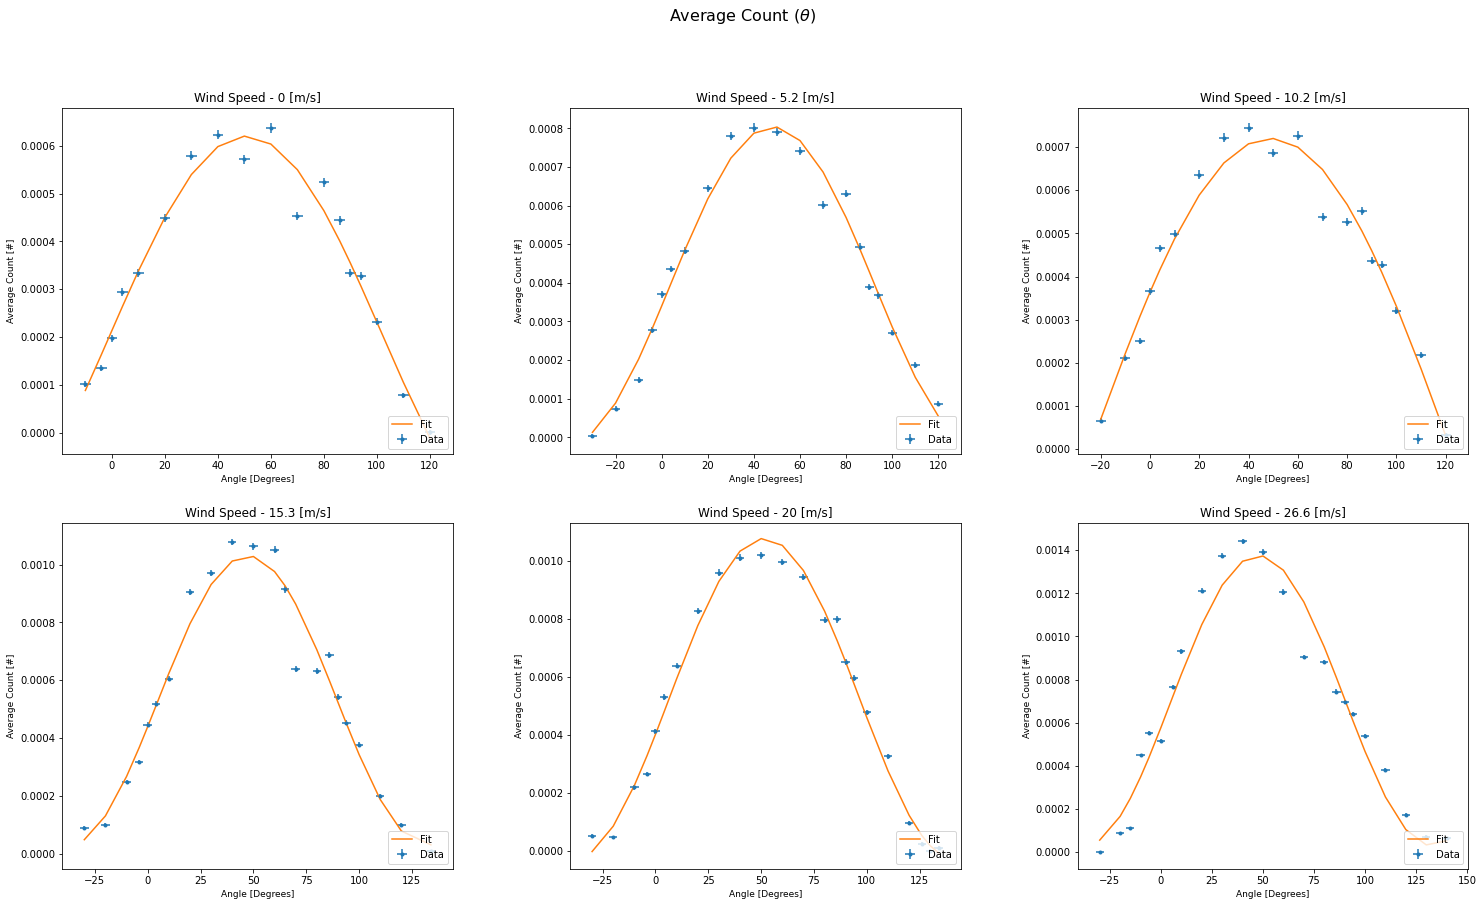

In [35]:
"""
Fit Graphs

Shows the graphs of the data with thier fit next to each other.
"""

#Preperation of the canvas.
original_size = plt.gcf().get_size_inches()

# Adjust the size to fit 6 plots in a 2x3 grid
new_size = (original_size[0] * 4.2, original_size[1] * 3.5)

# Create a figure with the adjusted size and a title
plt.figure(figsize=new_size).suptitle(r"Average Count ($\theta$)", fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.3)

# Ensure you're plotting only 6 plots in a 2x3 grid
def extract_float(s):
    return float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0])

# Filter out the folder you don't want and sort the rest
folders = sorted([i for i in results.keys() if i != '10.2 m_s - no fan'], key=extract_float)

#Reorganizing the data
for j, folder in enumerate(folders):
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2, :][np.argsort(data[2, :])]
    values = data[0, :][np.argsort(data[2, :])]
    error = data[1, :][np.argsort(data[2, :])]
     
    #making a copy for changes.    
    values_copy = list(np.copy(values))    
    angles_copy = list(np.copy(angles))    
    error_copy  = list(np.copy(error))    

    #Deletes bad data.
    for i,val in enumerate(values):
        if val <= 0:
            values_copy.remove(val)
            angles_copy.remove(angles[i])
            error_copy.remove(error[i])
      
    #Updating the arrays with the changes.
    values = np.array(list(values_copy))    
    angles = np.array(list(angles_copy))    
    error  = np.array(list(error_copy))   
    
    # Calculate the position in the 2x3 grid (3 columns, 2 rows)
    plt.subplot(2, 3, j + 1).set_title(f"Wind Speed - {folder.replace('m_s','[m/s]')}")

    #Adds the plot of the subfolder to the canvas.
    plt.errorbar(np.array(angles), np.array(values),
                 np.array(error), 2 * np.ones(len(angles)), '.', color='tab:blue', label="Data")

    #Calc. the values of the function with the fit parameters.
    fitting = func(np.array(angles), fit[folder][0][0], fit[folder][0][1], fit[folder][0][2], fit[folder][0][3])

    #Adds the fit to the graph.
    plt.plot(np.array(angles), fitting, color='tab:orange', label="Fit")
    plt.legend(loc='lower right')

    #Axis titles
    plt.xlabel("Angle [Degrees]", fontsize=9)
    plt.ylabel("Average Count [#]", fontsize=9)
    
    
# Display the figure
plt.show()


In [36]:
"""
Info about the fit

Calculations of different metrices that can help understand the Redundancy value. We look at:
1.Visibility
2.Angle Shift
3.Cos^2 Width

###Output:
-Prints with wind speed of the measurment with the value of the metrices.
"""

#Initialization of the list for the metrics.Vis = []
Max_teta = []
width = []

#Goes over the different subfolder's data.
for key in folders:    
    # Extract data for the current folder
    data = np.array([list(i) for i in results[key]]).T
    angles = data[2, :][np.argsort(data[2, :])]
    values = data[0, :][np.argsort(data[2, :])]
    values[values<0] = np.abs(values[values<0]) 
    
    # Generate the fitting curve
    fitting = func(np.array(angles), fit[key][0][0], fit[key][0][1], fit[key][0][2], fit[key][0][3]) 
    
    # Calculate the visibility
    sorted_values = np.sort(values)
    fit_max_val = np.mean(sorted_values[-4:])  # Mean of the top 3 values
    fit_min_val = np.mean(sorted_values[:4])   # Mean of the bottom 4 values
    Visibillit = (fit_max_val - fit_min_val) / (fit_max_val + fit_min_val)
    
    # Append results to lists
    Vis.append(Visibillit)
    Max_teta.append(fit[key][0][2])
    width.append(fit[key][0][1])
    
    # Print results for the current folder
    print(f"{key}:")
    print(f"RMSE = {np.sqrt(np.mean((values - fitting)**2)):.4f}")
    print(f'Visibility = {Visibillit:.4f}')
    print(f'Max at Theta = {fit[key][0][2]:.2f}')
    print('\n\n')



0 m_s:
RMSE = 0.0001
Visibility = 0.8668
Max at Theta = 50.70



5.2 m_s:
RMSE = 0.0000
Visibility = 0.9771
Max at Theta = 48.10



10.2 m_s:
RMSE = 0.0001
Visibility = 0.9412
Max at Theta = 48.81



15.3 m_s:
RMSE = 0.0001
Visibility = 0.9420
Max at Theta = 47.29



20 m_s:
RMSE = 0.0000
Visibility = 0.9586
Max at Theta = 51.51



26.6 m_s:
RMSE = 0.0001
Visibility = 0.9195
Max at Theta = 47.67





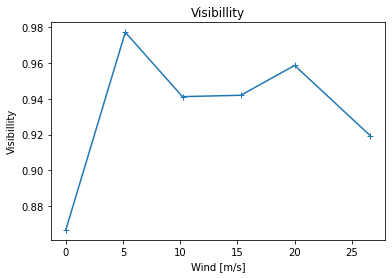

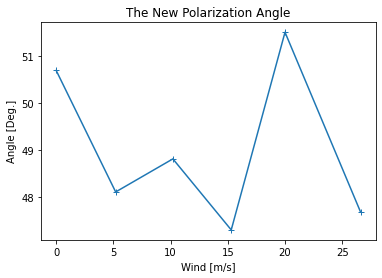

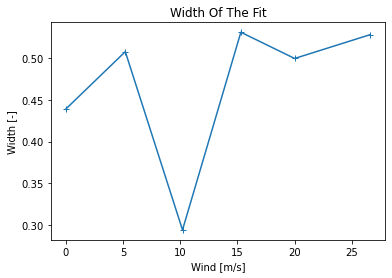

In [37]:
"""
Fit info Comparison between the diffrent wind parameters 

Plots a metrices value vs. wind speed graph.
"""

#Extracts the wind speed's value from the subfolders name.
wind = [float(i.split(" ")[0]) for i in folders]

plt.title("Visibillity")
plt.plot(np.array(wind), np.array(Vis), marker = '+')
plt.xlabel('Wind [m/s]')
plt.ylabel('Visibillity')
plt.show()

plt.title("The New Polarization Angle")
plt.plot(np.array(wind), np.array(Max_teta),marker = '+')
plt.xlabel('Wind [m/s]')
plt.ylabel('Angle [Deg.]')
plt.show()

plt.title("Width Of The Fit")
plt.plot(np.array(wind), np.array(width),marker = '+')
plt.xlabel('Wind [m/s]')
plt.ylabel('Width [-]')
plt.show()

<Figure size 432x288 with 0 Axes>

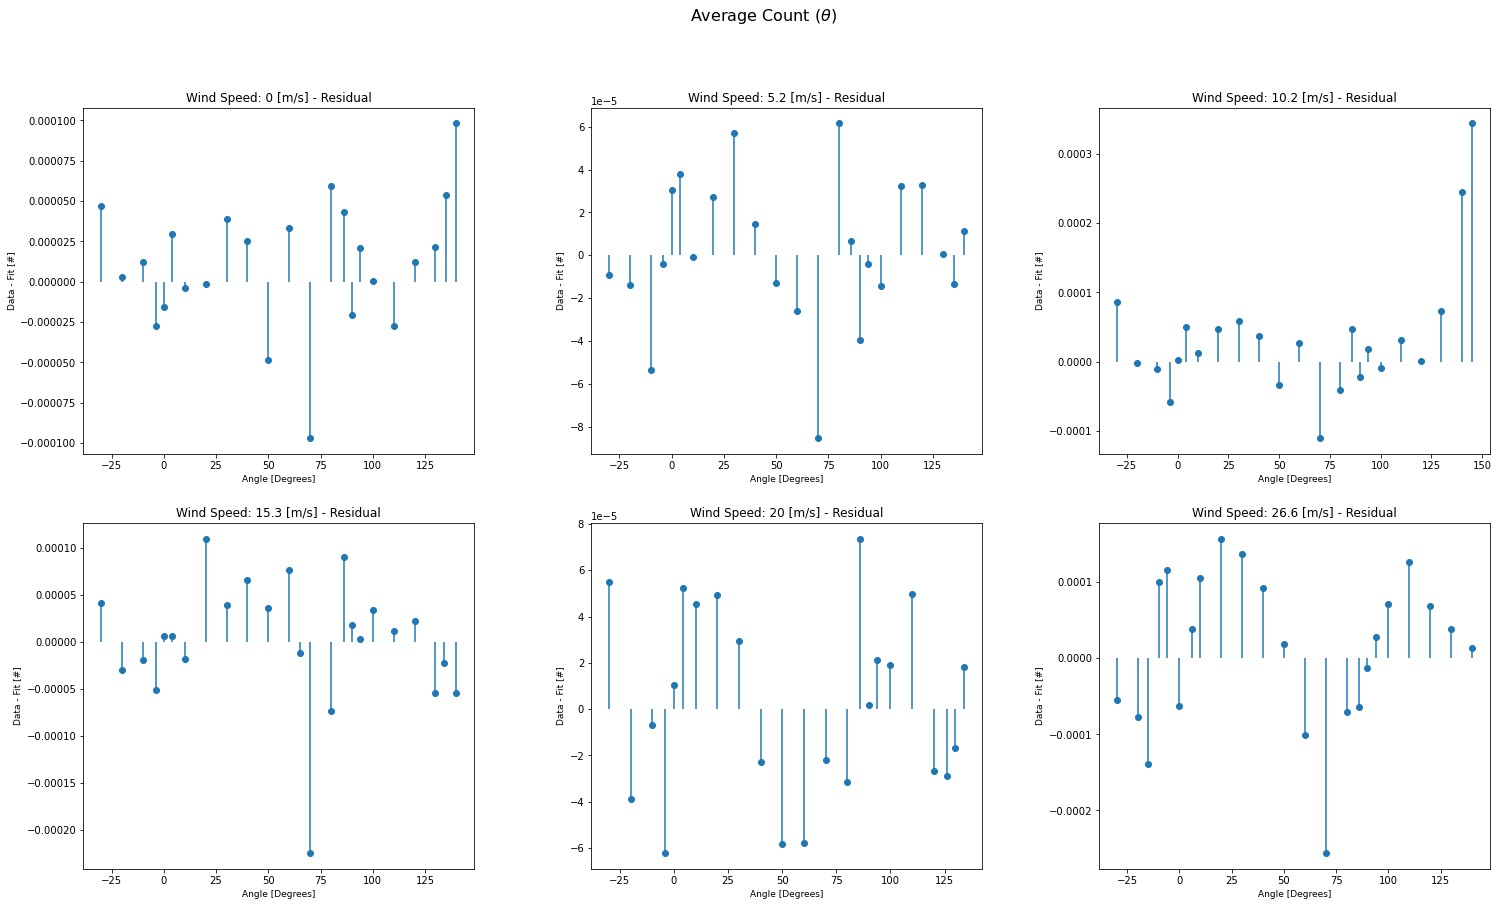

In [38]:
"""
Residuals Graphs (the fit function value substruct results)
"""


import matplotlib.pyplot as plt
import numpy as np
import re

# Get the original figure size
original_size = plt.gcf().get_size_inches()
# Adjust the size to fit 6 plots in a 2x3 grid
new_size = (original_size[0] * 4.2, original_size[1] * 3.5)

# Create a figure with the adjusted size and a title
plt.figure(figsize=new_size).suptitle(r"Average Count ($\theta$)", fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.3)

# Function to extract floats from strings
def extract_float(s):
    return float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0])

# Filter out the folder you don't want and sort the rest
folders = sorted([i for i in results.keys() if i != '10.2 m_s - no fan'], key=extract_float)

# Iterate over folders and plot the data
for j, folder in enumerate(folders):
    data = np.array([list(i) for i in results[folder]]).T
    angles = data[2, :][np.argsort(data[2, :])]
    values = data[0, :][np.argsort(data[2, :])]
    error = data[1, :][np.argsort(data[2, :])]
    
    # Plot each folder in a subplot
    plt.subplot(2, 3, j + 1).set_title(f"Wind Speed: {folder.replace('m_s','[m/s]')} - Residual")

    # Calculate the fitting curve
    fitting = func(angles, fit[folder][0][0], fit[folder][0][1], fit[folder][0][2], fit[folder][0][3])
    
    # Plot sticks (vertical lines)
    plt.vlines(angles, ymin=0, ymax=values- fitting, color='tab:blue')

    # Plot the residuals using dots at the end of each stick
    plt.scatter(angles, values - fitting, color='tab:blue')

    #Axis titles
    plt.xlabel("Angle [Degrees]", fontsize=9)
    plt.ylabel("Data - Fit [#]", fontsize=9)
    
# Display the figure
plt.show()


In [56]:
"""
Reynold's number calc.

Values scrapped from the table in:

https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm

"""
#Location of the experiment's folder.
main_directory = r"D:\TAU\Final_Project\final mes"

# Get the list of subfolders in the main directory
speeds = np.array([float(f.split(" ")[0]) for f in os.listdir(main_directory) if (f!="noise") and (not "no fan" in f)])

def Rey_num(V):
    #typical length [m] - optical distance
    L = 0.608 * 2
    
    #density of air [kg/m^3]
    p = 1.184 
    
    #dynemic viscosity of air
    u = 1.849 * 10**-5
    
    return V*L*p/u

print(f"Reynold's numbers: {[i for i in zip(speeds,Rey_num(speeds))]}")

Reynold's numbers: [(0.0, 0.0), (10.2, 794234.1157382367), (15.3, 1191351.1736073552), (20.0, 1557321.7955651702), (26.6, 2071237.9881016763), (5.2, 404903.66684694425)]
